First of all we define a center for each super pixels. according to number of super pixels we are looking for we can get distance between them and craete a grid like shape to specify centers. so:,

$$S = h * w$$ $$ k = number\; of \;super\; pixels$$ $$ grid\;size = \sqrt{\frac{S}{k}}$$

Then after defining centers, we move each center a little bit to have centers in better place(less gradient) we are looking for the best pixel in a 5*5 grid around each center. then we assign each pixel of the image to a cluster. in order to do that for each pixel we get four nearest centers and assign that to the most similar cluster center according to similarity function below:\n",

$$D = D_{lab} + \frac{m}{S} D_{xy}$$,

According to the SLIC paper, we set m = 10 to get better results.,
Then we update each cluster center by taking the mean of all points in each cluster(like what we did in k-Means algorithm). After a few iterations, centers converge.

To plot borders of super pixels, for each pixel we compare it with up, down,left and right pixel. if cluster centers was different the pixel is on the border and we set its value to zero. at last we will have black borders for each cuper pixel.

In [ ]:
import math
import cv2
import numpy as np
import tqdm
from matplotlib import pyplot as plt


def get_gradient(img):
    gradient_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    return np.mean(gradient, axis=2)


def get_feature_vectors(img):
    x_index, y_index = np.mgrid[:img.shape[0], :img.shape[1]]
    indexes = np.dstack((x_index, y_index))
    return np.dstack((img, indexes))


def init_cluster_centers(h, w, grid_size):
    x = list(range(grid_size, w, grid_size))
    y = list(range(grid_size, h, grid_size))
    xv, yv = np.meshgrid(x, y)
    return np.dstack((yv, xv))


def get_cluster_centers(gradient_img, h, w, grid_size, neighbour_len):
    cluster_centers = init_cluster_centers(h, w, grid_size)
    m, n, _ = cluster_centers.shape
    cluster_center = []
    for x in range(n):
        for y in range(m):
            min_value = math.inf
            min_index = [-1, -1]
            pixel = cluster_centers[y, x]
            pixel_x, pixel_y = pixel[1], pixel[0]
            half_len = int(neighbour_len / 2)

            x_begin = max(int(pixel_x - half_len), 0)
            x_end = min(int(pixel_x + half_len), w - 1)
            y_begin = max(int(pixel_y - half_len), 0)
            y_end = min(int(pixel_y + half_len), h - 1)

            for i in range(y_begin, y_end + 1):
                for j in range(x_begin, x_end + 1):
                    if gradient_img[i, j] < min_value:
                        min_value = gradient_img[i, j]
                        min_index = [i, j]
            pixel = min_index
            cluster_center.append(pixel)
    return np.array(cluster_center)


def slic(h, w, number_of_iterations, cluster_centers, feature_vectors, grid_size, m):
    clusters = np.zeros((h, w))
    D = np.ones((h, w)) * math.inf
    number_of_clusters = len(cluster_centers[:, 0])
    for iteration in tqdm.tqdm(range(number_of_iterations)):
        for cluster_index in range(number_of_clusters):
            cluster_center = cluster_centers[cluster_index]
            cluster_center_x, cluster_center_y = cluster_center[4], cluster_center[3]
            x_begin = max(int(cluster_center_x - grid_size), 0)
            x_end = min(int(cluster_center_x + grid_size + 1), w)
            y_begin = max(int(cluster_center_y - grid_size), 0)
            y_end = min(int(cluster_center_y + grid_size + 1), h)

            for i in range(y_begin, y_end):
                for j in range(x_begin, x_end):
                    point = feature_vectors[i, j]
                    point_x, point_y = point[4], point[3]
                    distance = np.sqrt((cluster_center_x - point_x) ** 2 + (cluster_center_y - point_y) ** 2)
                    color_distance = np.sqrt(np.sum(np.square(cluster_center[:3] - point[:3])))
                    dist = color_distance + distance * m / grid_size
                    if dist < D[i, j]:
                        D[i, j] = dist
                        clusters[i, j] = cluster_index

        for label in range(number_of_clusters):
            cluster_points = feature_vectors[clusters == label]
            if len(cluster_points) > 0:
                cluster_centers[label] = np.mean(cluster_points, axis=0)
    return clusters


def display_borders(img, clusters, h, w):
    borders = []
    for i in range(w):
        for j in range(h):
            for p, q in [(-1, 0), (0, -1), (0, 1), (1, 0)]:
                x, y = i + p, j + q
                if 0 <= x < w and 0 <= y < h:
                    if clusters[j, i] != clusters[y, x]:
                        borders.append([i, j])

    for i in range(len(borders)):
        img[borders[i][1], borders[i][0]] = 255
    return img


def process(img, k, neighbour_len, number_of_iterations, m, file_name):
    h, w, _ = img.shape
    grid_size = int(math.sqrt(h * w / k))
    feature_vectors = get_feature_vectors(img)
    gradient_img = get_gradient(img)
    cluster_centers = get_cluster_centers(gradient_img, h, w, grid_size, neighbour_len)
    cluster_centers = feature_vectors[tuple(cluster_centers.T)]
    clusters = slic(h, w, number_of_iterations, cluster_centers, feature_vectors, grid_size, m)
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    img = display_borders(img, clusters, h, w)
    cv2.imwrite(file_name, img)


image = plt.imread('brain.jpg')
#image = cv2.resize(image, (image.shape[1] // 7, image.shape[0] // 7))
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB).astype(float)
image = cv2.GaussianBlur(image, (5, 5), 3)

process(image, k=64, neighbour_len=5, number_of_iterations=2, m=10, file_name="res1.jpg")
process(image, k=256, neighbour_len=5, number_of_iterations=2, m=10, file_name="res2.jpg")
process(image, k=1024, neighbour_len=5, number_of_iterations=2, m=10, file_name="res3.jpg")
process(image, k=2048, neighbour_len=5, number_of_iterations=2, m=10, file_name="res4.jpg")

100%|██████████| 2/2 [08:34<00:00, 257.14s/it]


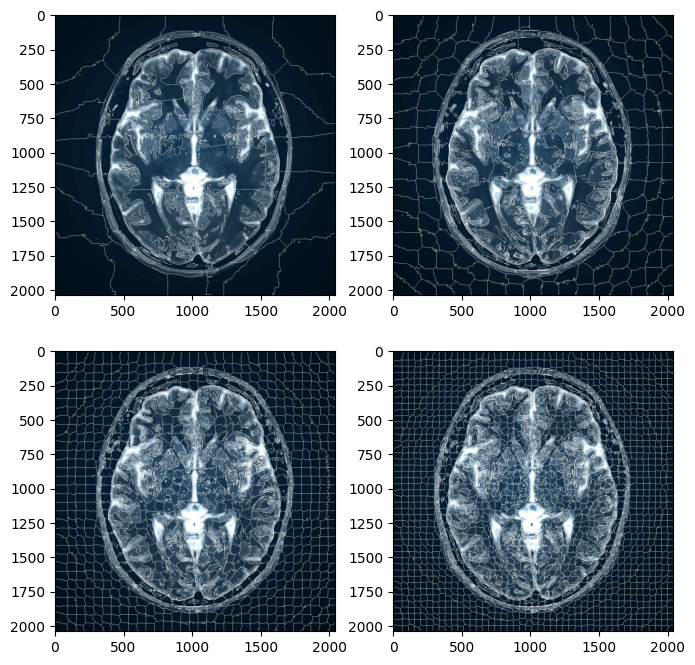

In [ ]:
# Import the matplotlib library
import matplotlib.pyplot as plt

# Create a figure object with a specified size
fig = plt.figure(figsize=(8, 8))

# Specify the number of rows and columns of subplots in the figure
rows = 2
columns = 2

# Load the images from files
img1 = plt.imread("res1.jpg")
img2 = plt.imread("res2.jpg")
img3 = plt.imread("res3.jpg")
img4 = plt.imread("res4.jpg")

# Add the images as subplots to the figure
fig.add_subplot(rows, columns, 1) # The first subplot in the first row
plt.imshow(img1) # Display the first image

fig.add_subplot(rows, columns, 2) # The second subplot in the first row
plt.imshow(img2) # Display the second image

fig.add_subplot(rows, columns, 3) # The third subplot in the second row
plt.imshow(img3) # Display the third image

fig.add_subplot(rows, columns, 4) # The fourth subplot in the second row
plt.imshow(img4) # Display the fourth image

# Show the figure with the images
plt.show()
